# Fairness and Accuracy in Machine Learning: Analysis

In this notebook, we explore various fairness and accuracy trade-offs in a machine learning model, using techniques like reweighting, counterfactual augmentation, and precision-recall evaluation.

## 1. Dataset Loading and Initial Setup
We start by loading the dataset and preprocessing it for analysis. In Google Colab, you need to upload your dataset.

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
url = 'https://raw.githubusercontent.com/SharonOkolo/Bias-in-online-datasets/refs/heads/main/adult_dataset.csv'
df = pd.read_csv(url)

In [2]:
print(df.head())

   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None


In [4]:
print(df.describe())

                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  48842.000000  4.884200e+04   48842.000000  48842.000000  48842.000000   
mean      38.643585  1.896641e+05      10.078089   1079.067626     87.502314   
std       13.710510  1.056040e+05       2.570973   7452.019058    403.004552   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175505e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.781445e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.376420e+05      12.000000      0.000000      0.000000   
max       90.000000  1.490400e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    48842.000000  
mean        40.422382  
std         12.391444  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  


In [5]:
print(df.isnull().sum())

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64


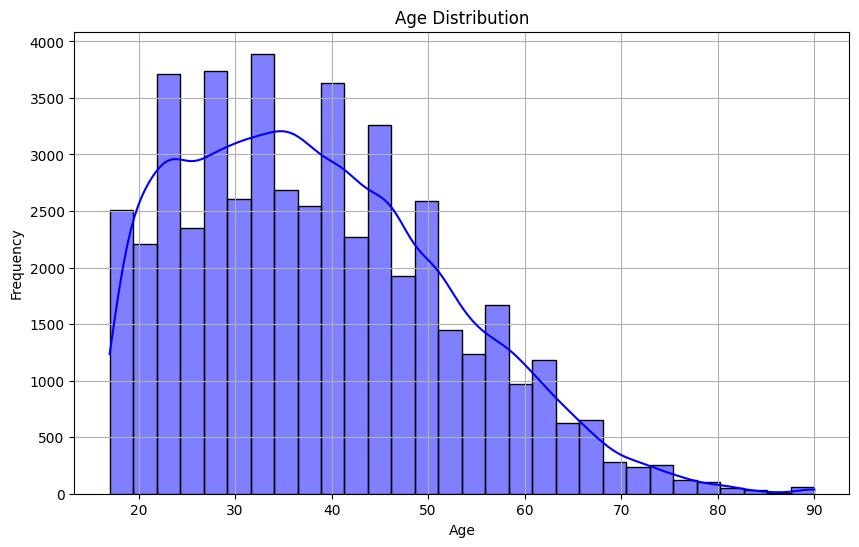

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=30, kde=True, color='blue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The age distribution shows that:

The majority of individuals in the dataset are between 20 and 60 years old. There's a peak around 30-40 years old, indicating a higher concentration of working-age adults. The distribution is slightly right-skewed, with fewer individuals in the older age ranges.

In [7]:
df['income'] = df['income'].replace(['>50K.'], '>50K')
df['income'] = df['income'].replace(['<=50K.', '<50K'], '<=50K')

<Figure size 1200x600 with 0 Axes>

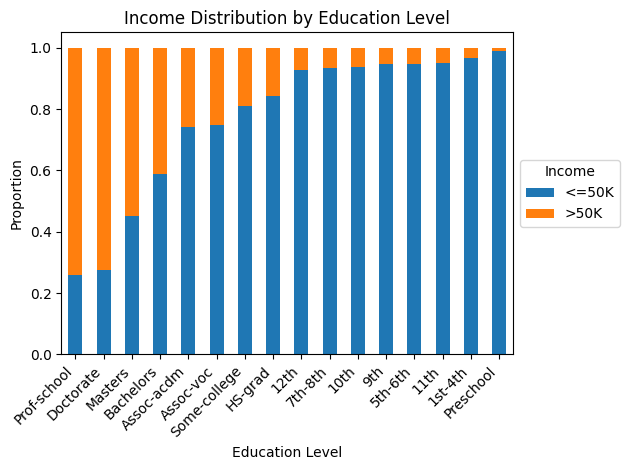

income           <=50K      >50K
education                       
Prof-school   0.260192  0.739808
Doctorate     0.274411  0.725589
Masters       0.450884  0.549116
Bachelors     0.587165  0.412835
Assoc-acdm    0.742036  0.257964
Assoc-voc     0.746725  0.253275
Some-college  0.810351  0.189649
HS-grad       0.841422  0.158578
12th          0.926941  0.073059
7th-8th       0.935079  0.064921
10th          0.937365  0.062635
9th           0.945767  0.054233
5th-6th       0.946955  0.053045
11th          0.949227  0.050773
1st-4th       0.967611  0.032389
Preschool     0.987952  0.012048


In [8]:
education_income = df.groupby('education')['income'].value_counts(normalize=True).unstack()
education_income = education_income.sort_values(by='>50K', ascending=False)

plt.figure(figsize=(12, 6))
education_income.plot(kind='bar', stacked=True)
plt.title('Income Distribution by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Proportion')
plt.legend(title='Income', loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(education_income)

This stacked bar chart shows the proportion of individuals earning <=50K and >50K for each education level. Key observations:

Higher education levels generally correspond to a higher proportion of individuals earning >50K. Doctorate and Professional school graduates have the highest proportion of high earners. As education level decreases, the proportion of individuals earning <=50K increases. Preschool and 1st-4th grade education levels have the highest proportion of low earners.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


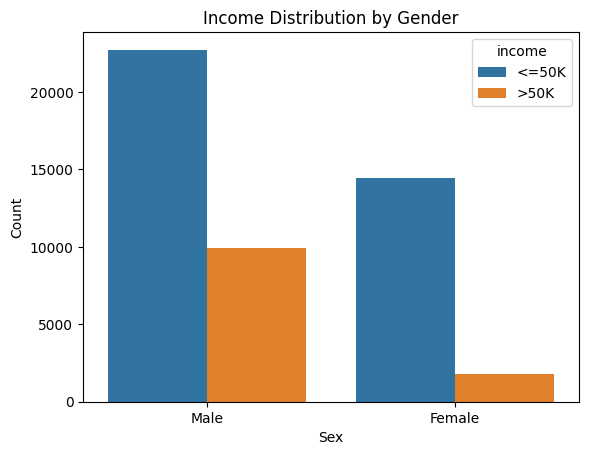

In [9]:
import seaborn as sns
sns.countplot(x='sex', hue='income', data=df)
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Income Distribution by Gender')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


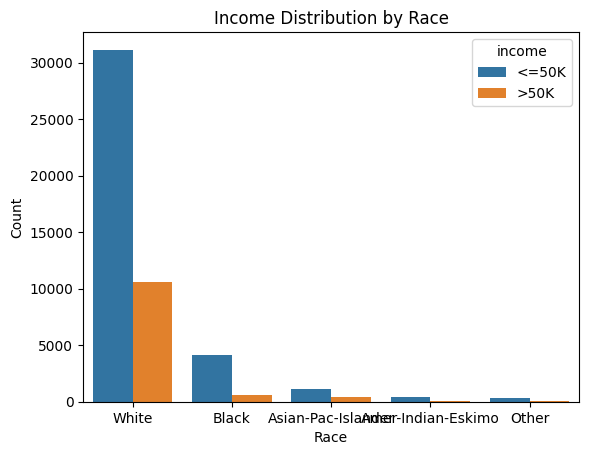

In [10]:
sns.countplot(x='race', hue='income', data=df)
plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Income Distribution by Race')
plt.show()

<ipython-input-11-1a038127af26>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


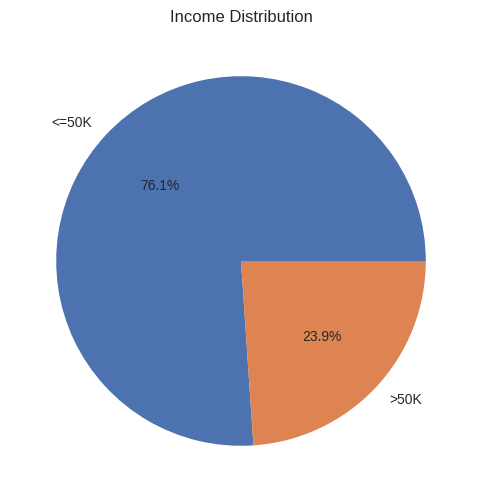

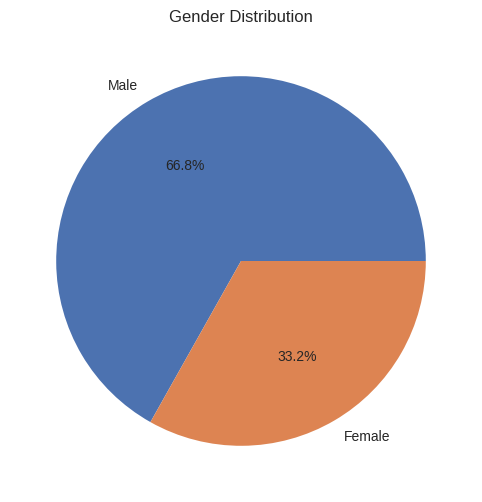

In [11]:
plt.style.use('seaborn')
sns.set_palette("deep")

plt.figure(figsize=(8, 6))
df['income'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Income Distribution')
plt.ylabel('')
plt.show()


plt.figure(figsize=(8, 6))
df['sex'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.ylabel('')
plt.show()

<Figure size 1200x600 with 0 Axes>

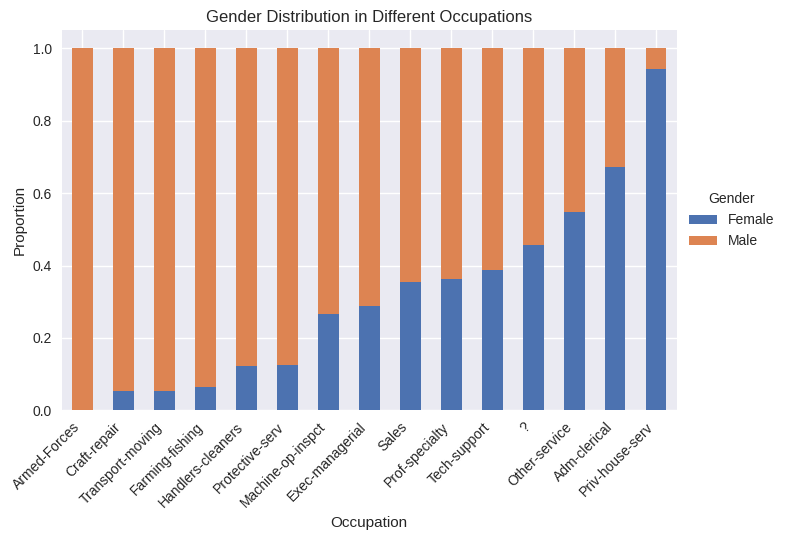

sex                  Female      Male
occupation                           
Armed-Forces            NaN  1.000000
Craft-repair       0.052847  0.947153
Transport-moving   0.053928  0.946072
Farming-fishing    0.063758  0.936242
Handlers-cleaners  0.122587  0.877413
Protective-serv    0.124110  0.875890
Machine-op-inspct  0.266049  0.733951
Exec-managerial    0.287217  0.712783
Sales              0.353743  0.646257
Prof-specialty     0.363253  0.636747
Tech-support       0.388658  0.611342
?                  0.456321  0.543679
Other-service      0.548040  0.451960
Adm-clerical       0.671716  0.328284
Priv-house-serv    0.942149  0.057851


In [12]:
gender_occupation = df.groupby('occupation')['sex'].value_counts(normalize=True).unstack()
gender_occupation = gender_occupation.sort_values(by='Male', ascending=False)

plt.figure(figsize=(12, 6))
gender_occupation.plot(kind='bar', stacked=True)
plt.title('Gender Distribution in Different Occupations')
plt.xlabel('Occupation')
plt.ylabel('Proportion')
plt.legend(title='Gender', loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(gender_occupation)

Numeric columns in the dataset:
Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


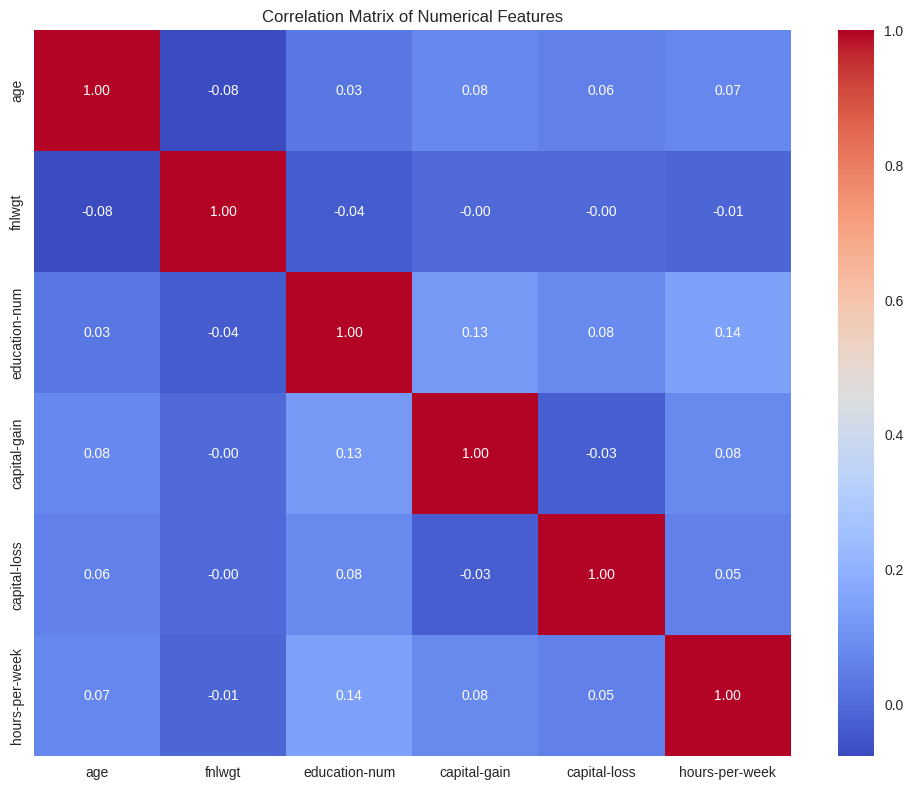

Correlation Matrix:
                     age    fnlwgt  education-num  capital-gain  capital-loss  \
age             1.000000 -0.076628       0.030940      0.077229      0.056944   
fnlwgt         -0.076628  1.000000      -0.038761     -0.003706     -0.004366   
education-num   0.030940 -0.038761       1.000000      0.125146      0.080972   
capital-gain    0.077229 -0.003706       0.125146      1.000000     -0.031441   
capital-loss    0.056944 -0.004366       0.080972     -0.031441      1.000000   
hours-per-week  0.071558 -0.013519       0.143689      0.082157      0.054467   

                hours-per-week  
age                   0.071558  
fnlwgt               -0.013519  
education-num         0.143689  
capital-gain          0.082157  
capital-loss          0.054467  
hours-per-week        1.000000  


In [13]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
print("Numeric columns in the dataset:")
print(numeric_columns)

correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

print("\
Correlation Matrix:")
print(correlation_matrix)

The correlation matrix shows the relationships between the numerical features in the dataset. Key observations:

Most correlations are relatively weak (close to 0). The strongest positive correlation (0.14) is between 'education-num' and 'hours-per-week', suggesting that individuals with higher education levels tend to work slightly more hours. There's a weak positive correlation (0.13) between 'education-num' and 'capital-gain', indicating that higher education might be associated with slightly higher capital gains. Age has weak positive correlations with 'capital-gain' (0.08) and 'hours-per-week' (0.07), suggesting that older individuals might have slightly higher capital gains and work slightly more hours. 'fnlwgt' (final weight) has weak negative correlations with most other features, but these correlations are close to 0 and might not be practically significant. These analyses provide insights into the demographics, education, income, and occupational characteristics of the individuals in the dataset. They reveal patterns in age distribution, the impact of education on income, gender disparities in various occupations, and relationships between numerical features.

## 2. Handling Missing Data and Outliers
We handle missing values and outliers in the dataset to ensure data quality.

In [14]:
df['workclass'] = df['workclass'].fillna(df['workclass'].mode()[0])
df['occupation'] = df['occupation'].fillna(df['occupation'].mode()[0])
df['native-country'] = df['native-country'].fillna(df['native-country'].mode()[0])


cap_gain_99 = df['capital-gain'].quantile(0.99)
cap_loss_99 = df['capital-loss'].quantile(0.99)

df['capital-gain'] = df['capital-gain'].apply(lambda x: cap_gain_99 if x > cap_gain_99 else x)
df['capital-loss'] = df['capital-loss'].apply(lambda x: cap_loss_99 if x > cap_loss_99 else x)


## 3. Encoding Categorical Variables
We perform one-hot encoding to convert categorical variables into numerical ones.

In [15]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40,Cuba,<=50K


In [16]:
# Encoding categorical variables
#df_encoded = pd.get_dummies(df, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income'], drop_first=True)

## 4. Bias Detection in Gender and Race
We check for bias in the `sex` and `race` columns by evaluating confusion matrices and accuracy.

In [17]:
bias_analysis_sex = pd.crosstab(df['sex'], df['income'])
bias_analysis_race = pd.crosstab(df['race'], df['income'])

bias_analysis_sex, bias_analysis_race


(income  <=50K  >50K
 sex                
 Female  14423  1769
 Male    22732  9918,
 income              <=50K   >50K
 race                            
 Amer-Indian-Eskimo    415     55
 Asian-Pac-Islander   1110    409
 Black                4119    566
 Other                 356     50
 White               31155  10607)

Explanation:
<=50K and <=50K. refer to people earning less than or equal to 50K in different race categories.
>50K and >50K. refer to people earning more than 50K.
For White individuals:
20,699 earn <=50K, and 10,456 earn <=50K..
7,117 earn >50K, and 3,490 earn >50K..
For Black individuals:
2,737 earn <=50K, and 1,382 earn <=50K..
387 earn >50K, and 179 earn >50K..
Amer-Indian-Eskimo and Other groups have much smaller populations in the dataset, with most earning <=50K.
Observation:

The White group dominates both the lower- and higher-income brackets, while minority groups, especially Black and Other, are less represented in the higher-income brackets.
The Asian-Pac-Islander group has a relatively higher proportion of individuals in the >50K income category compared to other minority groups.
Summary of Observations:
Gender Imbalance: There is a clear imbalance between males and females, with males more likely to earn higher incomes (>50K) than females.
Racial Disparities: There are significant differences in income distribution among different racial groups, with White individuals having the highest representation in higher-income categories, while other minority groups are disproportionately represented in lower-income brackets.
These insights highlight the potential bias in the dataset based on gender and race, which may affect the fairness of a predictive model trained on this data.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X = pd.get_dummies(df.drop('income', axis=1), drop_first=True)
y = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)


y_pred = log_reg.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\
Classification Report:")
print(class_report)

Confusion Matrix:
[[10390   719]
 [ 1499  2045]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     11109
           1       0.74      0.58      0.65      3544

    accuracy                           0.85     14653
   macro avg       0.81      0.76      0.78     14653
weighted avg       0.84      0.85      0.84     14653



In [19]:
df['native-country'] = df['native-country'].apply(lambda x: 1 if x == 'United-States' else 0)

In [20]:
df['income'] =  df['income'].apply(lambda x: 1 if x == '>50K' else 0)

In [21]:
df['is_male'] = df['sex'].apply(lambda x: 1 if x == 'Male' else 0)
df = df.drop('sex', axis=1)

In [22]:
df['race'] = df['race'].replace(['Black','Asian-Pac-Islander','Amer-Indian-Eskimo','Other'], 'Non-White')
df['is_white'] = df['race'].apply(lambda x: 1 if x == 'Non-White' else 0)
df = df.drop('race', axis=1)

In [23]:
df['marital-status'] = df['marital-status'].replace(['Divorced','Married-spouse-absent','Never-married','Separated','Widowed'],'Single')
df['marital-status'] = df['marital-status'].replace(['Married-AF-spouse','Married-civ-spouse'],'Married')
df['is_married'] = df['marital-status'].apply(lambda x: 1 if x == 'Single' else 0)
df = df.drop('marital-status', axis=1)

In [24]:
df['education'] = df['education'].replace(['Bachelors','Masters','Some-college','Assoc-acdm','Assoc-voc','Doctorate','Prof-school'],'Degree')
df['education'] = df['education'].replace(['HS-grad','11th','9th','7th-8th','5th-6th','10th','1st-4th','Preschool','12th'],'Non-Degree')
df['education'] = df['education'].apply(lambda x: 1 if x == 'Non-Degree' else 0)

In [25]:
df['occupation'] = df['occupation'].replace(['Prof-specialty','Exec-manageial'],'A')
df['occupation'] = df['occupation'].replace(['Adm-clerical','Sales','Machine-op-inspct','Tech-support','Protective-serv','Armed-Forces'],'B')
df['occupation'] = df['occupation'].replace(['Handlers-cleaners','Other-service','Craft-repair','Transport-moving','Farming-fishing','Priv-house-serv'],'C')
df['occupation'] = df['occupation'].apply(lambda x: 1 if x == 'A' else 2 if x == 'B' else 0)

In [26]:
df['relationship'] = df['relationship'].replace(['Husband','Wife'],'Spouse')
df['relationship'] = df['relationship'].replace(['Not-in-family','Other-relative','Unmarried'],'Not-Spouse')
df['relationship'] = df['relationship'].apply(lambda x: 1 if x == 'Not-Spouse' else 2 if x == 'Own-child' else 0)

In [27]:
df['workclass'] = df['workclass'].replace(['Federal-gov','Local-gov','State-gov'],'Gov')
df['workclass'] = df['workclass'].replace(['Self-emp-not-inc','Self-emp-inc'],'Self-Employed')
df['workclass'] = df['workclass'].replace(['Without-pay','Never-worked'],'Unemployed')
df['workclass'] = df['workclass'].apply(lambda x: 1 if x == 'Gov' else 2 if x == 'Self-Employed' else 3 if x == 'Private' else 0)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier

In [29]:
X = df.drop('income', axis=1)
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
def get_preds(x_train, Y_train, x_test):
  clf=LogisticRegression(max_iter=1000)
  clf.fit(x_train, Y_train)
  y_pred=clf.predict(x_test)
  return y_pred
y_pred=get_preds(X_train, y_train, X_test)
print(accuracy_score(y_test, y_pred))

0.8315078308936431


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for Female: 0.9224
Accuracy for Male: 0.7866

Rates for Female:
True Positive Rate: 0.44
False Positive Rate: 0.02
True Negative Rate: 0.98
False Negative Rate: 0.56

Rates for Male:
True Positive Rate: 0.6
False Positive Rate: 0.13
True Negative Rate: 0.87
False Negative Rate: 0.4


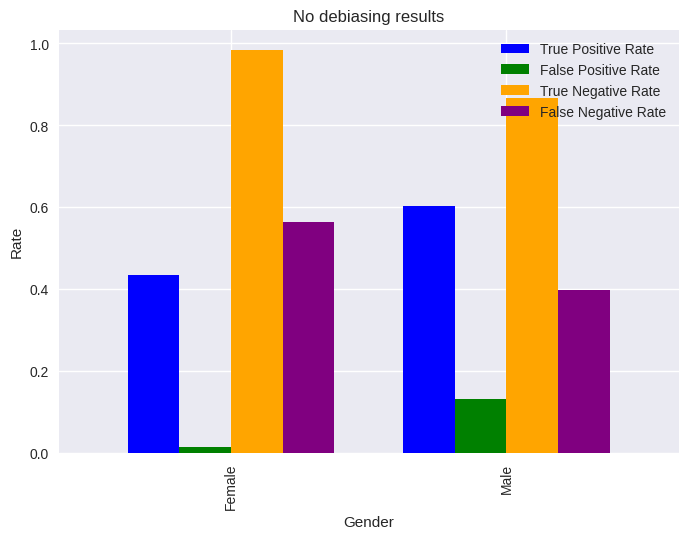

In [31]:
def create_gender_df(result, x_test, Y_test, Y_pred):
  df=pd.DataFrame(x_test, columns=result.drop('income', axis=1).columns)
  df['true_label']=Y_test
  df['predicted_label']=Y_pred
  return df

def gender_plot_rates(gender_result, title='Gender_Results'):
    genders = {0: 'Female', 1: 'Male'}
    rates = {}
    grouped = gender_result.groupby('is_male')
    for name, group in grouped:
        accuracy = accuracy_score(group['true_label'], group['predicted_label'])
        print(f"Accuracy for {genders[name]}: {round(accuracy, 4)}")


        tn, fp, fn, tp = confusion_matrix(group['true_label'], group['predicted_label']).ravel()
        rates[name] = {
            'True Positive Rate': tp / (tp + fn),
            'False Positive Rate': fp / (fp + tn),
            'True Negative Rate': tn / (tn + fp),
            'False Negative Rate': fn / (fn + tp)}

    df_rates = pd.DataFrame(rates).T

    for index, row in df_rates.iterrows():
        print(f"\nRates for {genders[index]}:")
        for rate_name, rate_value in row.items():
            print(f"{rate_name}: {round(rate_value, 2)}")


    df_rates.plot(kind='bar', width=0.75, color= ['blue', 'green', 'orange', 'purple'])
    plt.ylabel('Rate')
    plt.xticks([0, 1], ['Female', 'Male'])
    plt.xlabel('Gender')
    plt.title(title)
    plt.show()

df_no_gender_debiasing = create_gender_df(df, X_test, y_test, y_pred)
gender_plot_rates(df_no_gender_debiasing, title='No debiasing results')

Gender Unawareness

In [32]:
X_train, X_test, y_train, y_test=  train_test_split(X,y, test_size=0.2, random_state=42)
test_gender=X_test['is_male']
X_test=X_test.drop('is_male', axis=1)
X_train=X_train.drop('is_male', axis=1)
y_pred=get_preds(X_train, y_train, X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Overall Accuracy: 0.8309
Accuracy for Female: 0.9193
Accuracy for Male: 0.7872

Rates for Female:
True Positive Rate: 0.48
False Positive Rate: 0.02
True Negative Rate: 0.98
False Negative Rate: 0.52

Rates for Male:
True Positive Rate: 0.6
False Positive Rate: 0.13
True Negative Rate: 0.87
False Negative Rate: 0.4


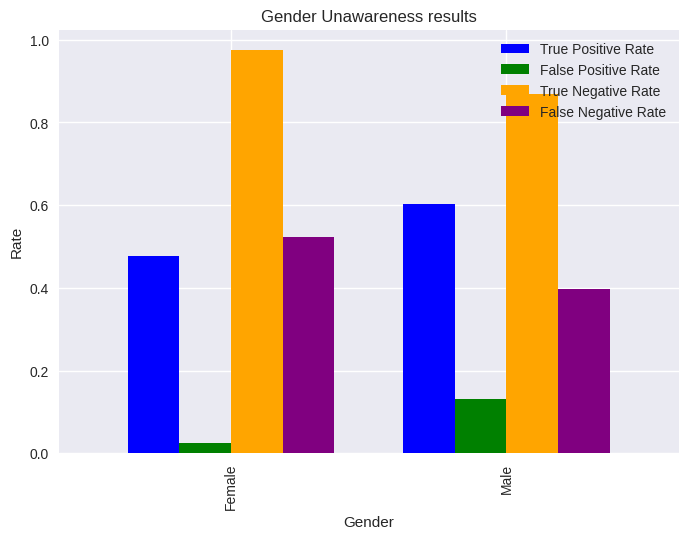

In [33]:
X_test['is_male']= test_gender
print(f"Overall Accuracy: {round(accuracy_score(y_test, y_pred), 4)}")
df_gender_unawareness= create_gender_df(df,X_test, y_test,y_pred)
gender_plot_rates(df_gender_unawareness, title="Gender Unawareness results")

Gender Balanced

In [34]:
males, females= df[df.is_male==1], df[df.is_male==0]
sampled_males= males.sample(n=int(min(females.shape[0], males.shape[0]))).reset_index(drop=True)
combined=pd.concat([sampled_males, females]).sample(frac=1).reset_index(drop=True)
Xvals=combined.drop(["income"], axis=1)
Yvals=combined["income"]
X_train, X_test, y_train, y_test=train_test_split(Xvals, Yvals, test_size=0.2, random_state=42)



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Overall Accuracy: 0.8552
Accuracy for Female: 0.9182
Accuracy for Male: 0.7935

Rates for Female:
True Positive Rate: 0.39
False Positive Rate: 0.02
True Negative Rate: 0.98
False Negative Rate: 0.61

Rates for Male:
True Positive Rate: 0.64
False Positive Rate: 0.14
True Negative Rate: 0.86
False Negative Rate: 0.36


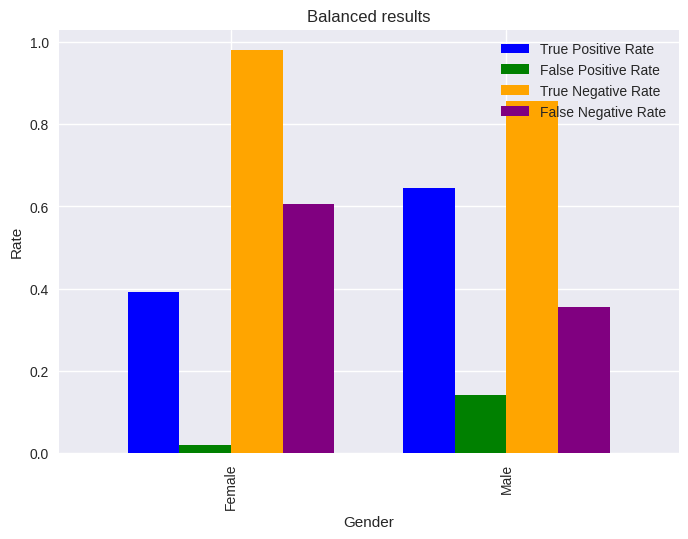

In [35]:
y_pred=get_preds(X_train, y_train, X_test)

print(f"Overall Accuracy: {round(accuracy_score(y_test, y_pred), 4)}")
df_balanced= create_gender_df(df, X_test, y_test, y_pred)
gender_plot_rates(df_balanced, title='Balanced results')

Target Ratio Balance

In [36]:
males, females= df[df.is_male==1], df[df.is_male==0]
male_high=males[(males.income==1)]
male_low=males[(males.income==0)]
female_high=females[(females.income==1)]
female_low=females[(females.income==0)]
print("shapes mh, ml, fh, fl:", [x.shape[0] for x  in [male_high, male_low, female_high, female_low]])
ratio= float(male_high.shape[0])/ float(male_low.shape[0])
print("Ratio is", ratio)

shapes mh, ml, fh, fl: [9918, 22732, 1769, 14423]
Ratio is 0.43630124934013725


In [37]:
n_female_high= female_high.shape[0]
n_female_low= int(n_female_high / ratio)

_male_low= male_low.copy()
_male_high=male_high.copy()
_female_high= female_high.copy()
_female_low=female_low.sample(n=n_female_low).reset_index(drop=True)
_combined=pd.concat([_male_high, _male_low,_female_high, _female_low]).sample(frac=1).reset_index(drop=True)
Xvals= _combined.drop(["income"], axis=1)
Yvals=_combined["income"]
X_train, X_test, y_train, y_test= train_test_split(Xvals, Yvals, test_size=0.2, random_state=42)
y_pred=get_preds(X_train,y_train, X_test )

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Overall Accuracy: 0.7919
Accuracy for Female: 0.8459
Accuracy for Male: 0.7823

Rates for Female:
True Positive Rate: 0.63
False Positive Rate: 0.05
True Negative Rate: 0.95
False Negative Rate: 0.37

Rates for Male:
True Positive Rate: 0.63
False Positive Rate: 0.15
True Negative Rate: 0.85
False Negative Rate: 0.37


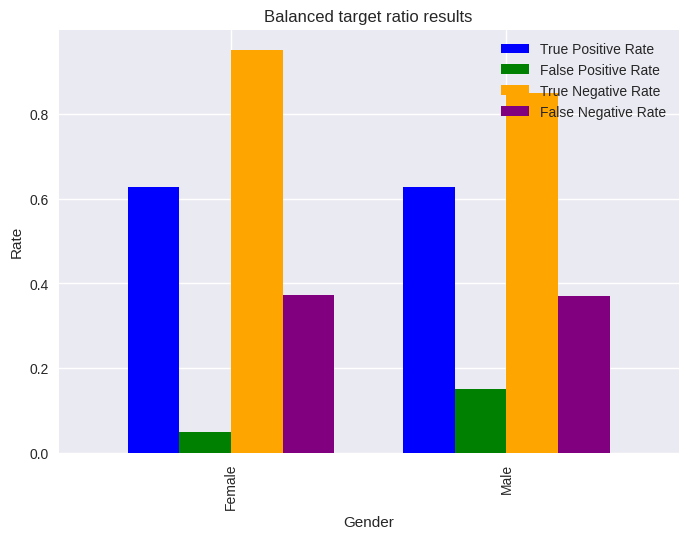

In [38]:
print(f"Overall Accuracy: {round(accuracy_score(y_test, y_pred), 4)}")
df_gender_ratio= create_gender_df(df, X_test, y_test, y_pred)
gender_plot_rates(df_gender_ratio, title="Balanced target ratio results")

Gender Counterfactual Augmentation

In [39]:
df_gender_tmp=df.copy()
df_gender_tmp['is_male']=df_gender_tmp['is_male'].apply(lambda value: 1-value)
df_gender_aug=pd.concat([df.copy(), df_gender_tmp])
X=df_gender_aug.drop('income', axis=1)
y=df_gender_aug['income']
X_train, X_test,y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=42)
y_pred=get_preds(X_train, y_train, X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Overall Accuracy: 0.8324
Accuracy for Female: 0.8349
Accuracy for Male: 0.83

Rates for Female:
True Positive Rate: 0.61
False Positive Rate: 0.09
True Negative Rate: 0.91
False Negative Rate: 0.39

Rates for Male:
True Positive Rate: 0.54
False Positive Rate: 0.08
True Negative Rate: 0.92
False Negative Rate: 0.46


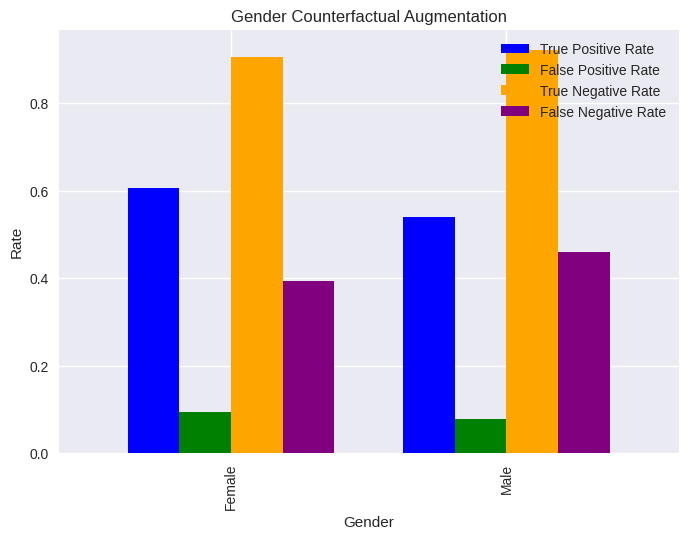

In [40]:
print(f"Overall Accuracy: {round(accuracy_score(y_test, y_pred), 4)}")
df_gender_aug=create_gender_df(df, X_test, y_test, y_pred)
gender_plot_rates(df_gender_aug, title='Gender Counterfactual Augmentation')

In [41]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split


# def calculate_gender_weights(df, sensitive_attribute):

#   total_count = len(df)
#   group_counts = df.groupby(sensitive_attribute).size()
#   gender_weights = total_count / (len(df) * group_counts[df[sensitive_attribute]])
#   return gender_weights

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Calculate the weights for the training data
# gender_weights = calculate_gender_weights(pd.concat([X_train, y_train], axis=1), 'is_male')

# # Train the model with reweighting
# clf = LogisticRegression(max_iter=1000)
# clf.fit(X_train, y_train, sample_weight=gender_weights)

# # Make predictions on the test set
# y_pred = clf.predict(X_test)

# # Evaluate the model's accuracy
# print(f"Accuracy with Reweighting: {round(accuracy_score(y_test, y_pred), 4)}")

# # Further analysis and evaluation can be performed here, including checking for
# # fairness metrics such as equal opportunity or disparate impact.


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def calculate_gender_weights(df, sensitive_attribute):

  total_count = len(df)
  group_counts = df.groupby(sensitive_attribute).size()
  gender_weights = total_count / (len(df) * group_counts[df[sensitive_attribute]])
  return gender_weights

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gender_weights = calculate_gender_weights(pd.concat([X_train, y_train], axis=1), 'is_male')


clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train, sample_weight=gender_weights)

y_pred = clf.predict(X_test)


print(f"Accuracy with Reweighting: {round(accuracy_score(y_test, y_pred), 4)}")


Accuracy with Reweighting: 0.8094


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Overall Accuracy: 0.8094
Accuracy for Female: 0.8129
Accuracy for Male: 0.8059

Rates for Female:
True Positive Rate: 0.29
False Positive Rate: 0.03
True Negative Rate: 0.97
False Negative Rate: 0.71

Rates for Male:
True Positive Rate: 0.28
False Positive Rate: 0.03
True Negative Rate: 0.97
False Negative Rate: 0.72


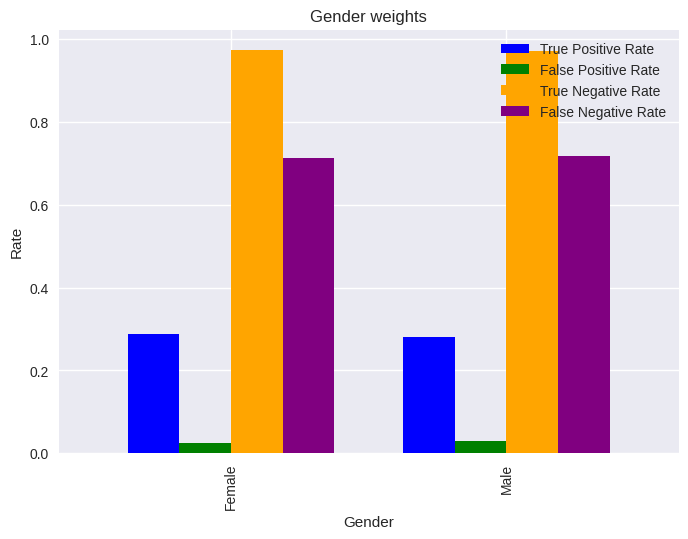

In [43]:
print(f"Overall Accuracy: {round(accuracy_score(y_test, y_pred), 4)}")
df_gender_weight = pd.DataFrame({'true_label': y_test, 'predicted_label': y_pred})
df_gender_weight['is_male'] = X_test['is_male']

gender_plot_rates(df_gender_weight, title='Gender weights')

In [44]:
def gender_compare_results(df_no_gender_debiasing, df_gender_unawareness, df_balanced, df_gender_ratio, df_gender_aug):


  print("Comparing Results from Different Debiasing Methods:")

  def calculate_metrics(df):
    """Calculates overall accuracy and accuracy for each gender."""
    overall_accuracy = accuracy_score(df['true_label'], df['predicted_label'])
    female_accuracy = accuracy_score(df[df['is_male'] == 0]['true_label'], df[df['is_male'] == 0]['predicted_label'])
    male_accuracy = accuracy_score(df[df['is_male'] == 1]['true_label'], df[df['is_male'] == 1]['predicted_label'])
    return overall_accuracy, female_accuracy, male_accuracy

  methods = {
      "No Debiasing": df_no_gender_debiasing,
      "Gender Unawareness": df_gender_unawareness,
      "Balanced Dataset": df_balanced,
      "Balanced Target Ratio": df_gender_ratio,
      "Counterfactual Augmentation": df_gender_aug
  }

  for method_name, df in methods.items():
    overall_accuracy, female_accuracy, male_accuracy = calculate_metrics(df)
    print(f"\n{method_name}:")
    print(f"  Overall Accuracy: {round(overall_accuracy, 4)}")
    print(f"  Female Accuracy: {round(female_accuracy, 4)}")
    print(f"  Male Accuracy: {round(male_accuracy, 4)}")

gender_compare_results(df_no_gender_debiasing, df_gender_unawareness, df_balanced, df_gender_ratio, df_gender_aug)



Comparing Results from Different Debiasing Methods:

No Debiasing:
  Overall Accuracy: 0.8315
  Female Accuracy: 0.9224
  Male Accuracy: 0.7866

Gender Unawareness:
  Overall Accuracy: 0.8309
  Female Accuracy: 0.9193
  Male Accuracy: 0.7872

Balanced Dataset:
  Overall Accuracy: 0.8552
  Female Accuracy: 0.9182
  Male Accuracy: 0.7935

Balanced Target Ratio:
  Overall Accuracy: 0.7919
  Female Accuracy: 0.8459
  Male Accuracy: 0.7823

Counterfactual Augmentation:
  Overall Accuracy: 0.8324
  Female Accuracy: 0.8349
  Male Accuracy: 0.83


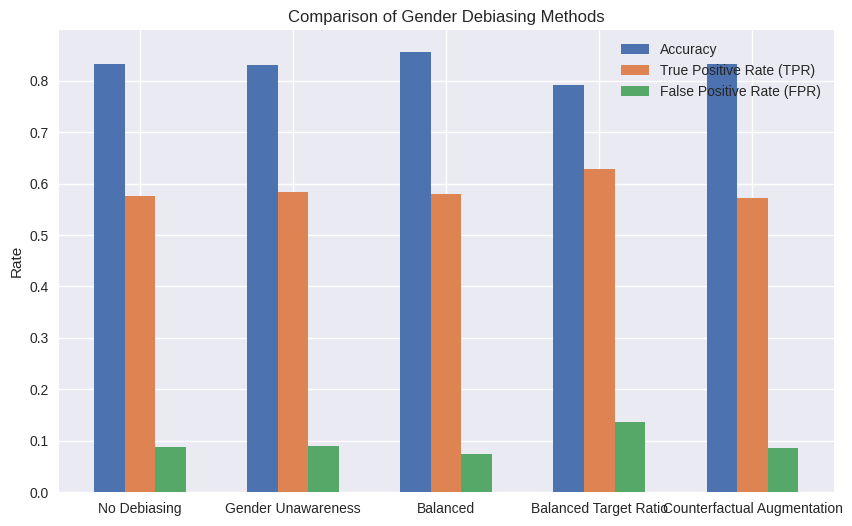

In [45]:
import matplotlib.pyplot as plt


def calculate_accuracy_and_tpr_fpr(df):
  """Calculates the accuracy, TPR, and FPR for a given DataFrame."""
  accuracy = accuracy_score(df['true_label'], df['predicted_label'])
  tn, fp, fn, tp = confusion_matrix(df['true_label'], df['predicted_label']).ravel()
  tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
  fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
  return accuracy, tpr, fpr

gender_results = {
    'No Debiasing': calculate_accuracy_and_tpr_fpr(df_no_gender_debiasing),
    'Gender Unawareness': calculate_accuracy_and_tpr_fpr(df_gender_unawareness),
    'Balanced': calculate_accuracy_and_tpr_fpr(df_balanced),
    'Balanced Target Ratio': calculate_accuracy_and_tpr_fpr(df_gender_ratio),
    'Counterfactual Augmentation': calculate_accuracy_and_tpr_fpr(df_gender_aug),
}

labels = list(gender_results.keys())
accuracies = [result[0] for result in gender_results.values()]
tprs = [result[1] for result in gender_results.values()]
fprs = [result[2] for result in gender_results.values()]

x = range(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x, accuracies, width, label='Accuracy')
rects2 = ax.bar([i + width for i in x], tprs, width, label='True Positive Rate (TPR)')
rects3 = ax.bar([i + 2 * width for i in x], fprs, width, label='False Positive Rate (FPR)')

ax.set_ylabel('Rate')
ax.set_title('Comparison of Gender Debiasing Methods')
ax.set_xticks([i + width for i in x])
ax.set_xticklabels(labels)
ax.legend()

plt.show()


Number of females before resampling: 16192
Number of Non-Whites before resampling: 32650


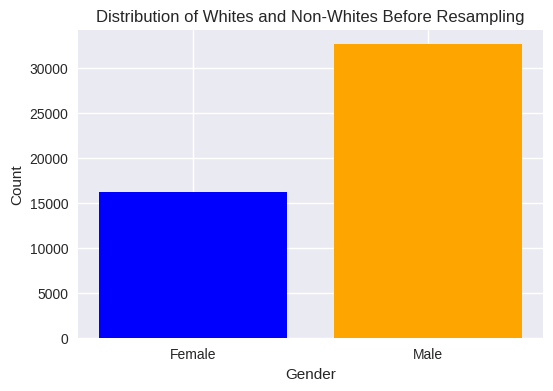

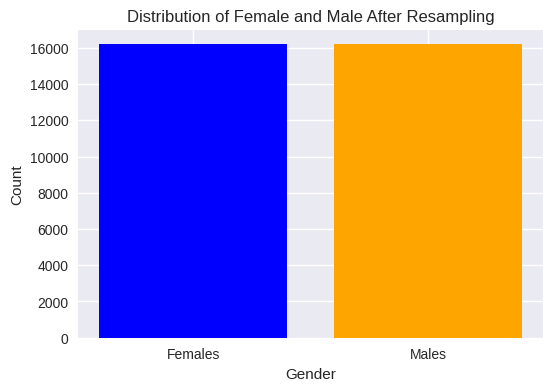

Overall Accuracy: 0.8683

Female - True Positive Rate (TPR): 0.4669
Female - False Positive Rate (FPR): 0.0161
Female - True Negative Rate (TNR): 0.9839
Female - False Negative Rate (FNR): 0.5331

Male - True Positive Rate (TPR): 0.5988
Male - False Positive Rate (FPR): 0.1001
Male - True Negative Rate (TNR): 0.8999
Male - False Negative Rate (FNR): 0.4012


array([[3111,  346],
       [ 583,  870]])

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

females = df[df['is_male'] == 0]
males = df[df['is_male'] == 1]


print(f"Number of females before resampling: {len(females)}")
print(f"Number of Non-Whites before resampling: {len(males)}")

plt.figure(figsize=(6, 4))
plt.bar(['Female', 'Male'], [len(females), len(males)], color=['blue', 'orange'])
plt.title('Distribution of Whites and Non-Whites Before Resampling')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


if len(females) > len(males):
    females_resampled = females.sample(n=len(males), random_state=42)
    df_balanced = pd.concat([females_resampled, males], axis=0)
else:
    males_resampled = males.sample(n=len(females), random_state=42)
    df_balanced = pd.concat([males_resampled, females], axis=0)


df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


females_after = df_balanced[df_balanced['is_male'] == 0]
males_after = df_balanced[df_balanced['is_male'] == 1]

plt.figure(figsize=(6, 4))
plt.bar(['Females', 'Males'], [len(females_after), len(males_after)], color=['blue', 'orange'])
plt.title('Distribution of Female and Male After Resampling')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

X = df_balanced.drop('income', axis=1)
y = df_balanced['income']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(solver='liblinear', max_iter=5000)
log_reg.fit(X_train_scaled, y_train)


y_pred = log_reg.predict(X_test_scaled)


overall_accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {overall_accuracy:.4f}")


def compute_rates_for_group_gender(y_true, y_pred, group_name):
    conf_matrix = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = conf_matrix.ravel()


    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    TNR = TN / (TN + FP)
    FNR = FN / (FN + TP)

    print(f"\n{group_name} - True Positive Rate (TPR): {TPR:.4f}")
    print(f"{group_name} - False Positive Rate (FPR): {FPR:.4f}")
    print(f"{group_name} - True Negative Rate (TNR): {TNR:.4f}")
    print(f"{group_name} - False Negative Rate (FNR): {FNR:.4f}")
    return conf_matrix


females_mask = X_test['is_male'] == 0
compute_rates_for_group_gender(y_test[females_mask], y_pred[females_mask], "Female")


males_mask = X_test['is_male'] == 1
compute_rates_for_group_gender(y_test[males_mask], y_pred[males_mask], "Male")


Racial

Accuracy for White: 0.8596
Accuracy for Non-White: 0.9143

Rates for White:
True Positive Rate: 0.57
False Positive Rate: 0.06
True Negative Rate: 0.94
False Negative Rate: 0.43

Rates for Non-White:
True Positive Rate: 0.47
False Positive Rate: 0.03
True Negative Rate: 0.97
False Negative Rate: 0.53


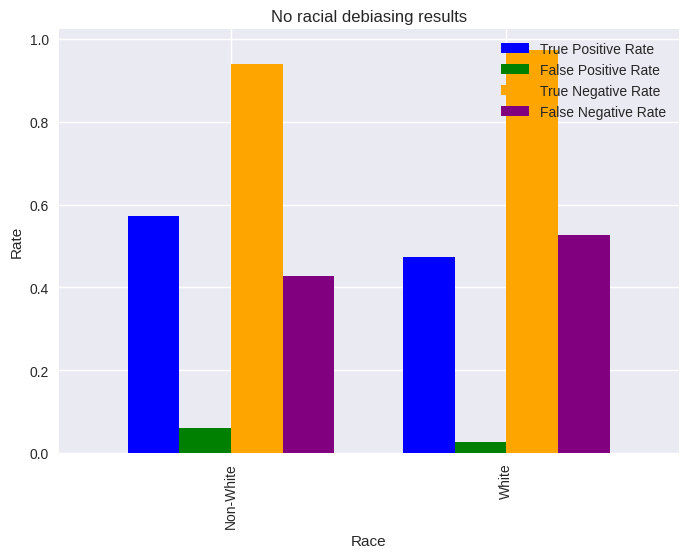

In [47]:
def create_racial_df(result, x_test, Y_test, Y_pred):
  df=pd.DataFrame(x_test, columns=result.drop('income', axis=1).columns)
  df['true_label']=Y_test
  df['predicted_label']=Y_pred
  return df

def plot_rates(result, title='Results'):
    races = {0: 'White', 1: 'Non-White'}
    rates = {}
    grouped = result.groupby('is_white')
    for name, group in grouped:
        # Calculate accuracy
        accuracy = accuracy_score(group['true_label'], group['predicted_label'])
        print(f"Accuracy for {races[name]}: {round(accuracy, 4)}")

        # Calculate confusion matrix rates
        tn, fp, fn, tp = confusion_matrix(group['true_label'], group['predicted_label']).ravel()
        rates[name] = {
            'True Positive Rate': tp / (tp + fn),
            'False Positive Rate': fp / (fp + tn),
            'True Negative Rate': tn / (tn + fp),
            'False Negative Rate': fn / (fn + tp)}

    # Convert the rates dictionary to a DataFrame for easier plotting and analysis
    df_rates = pd.DataFrame(rates).T

    # Print the rates for each gender
    for index, row in df_rates.iterrows():
        print(f"\nRates for {races[index]}:")
        for rate_name, rate_value in row.items():
            print(f"{rate_name}: {round(rate_value, 2)}")

    # Plot the rates
    df_rates.plot(kind='bar', width=0.75, color= ['blue', 'green', 'orange', 'purple'])
    plt.ylabel('Rate')
    plt.xticks([0, 1], ['Non-White', 'White'])
    plt.xlabel('Race')
    plt.title(title)
    plt.show()
  # Example usage:
df_no_racial_debiasing = create_racial_df(df, X_test, y_test, y_pred)
plot_rates(df_no_racial_debiasing, title='No racial debiasing results')

Racial Unawareness

In [48]:
X_train, X_test, y_train, y_test=  train_test_split(X,y, test_size=0.2, random_state=42)
test_race=X_test['is_white']
X_test=X_test.drop('is_white', axis=1)
X_train=X_train.drop('is_white', axis=1)
y_pred=get_preds(X_train, y_train, X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Overall Accuracy: 0.8614
Accuracy for White: 0.853
Accuracy for Non-White: 0.9061

Rates for White:
True Positive Rate: 0.58
False Positive Rate: 0.07
True Negative Rate: 0.93
False Negative Rate: 0.42

Rates for Non-White:
True Positive Rate: 0.57
False Positive Rate: 0.05
True Negative Rate: 0.95
False Negative Rate: 0.43


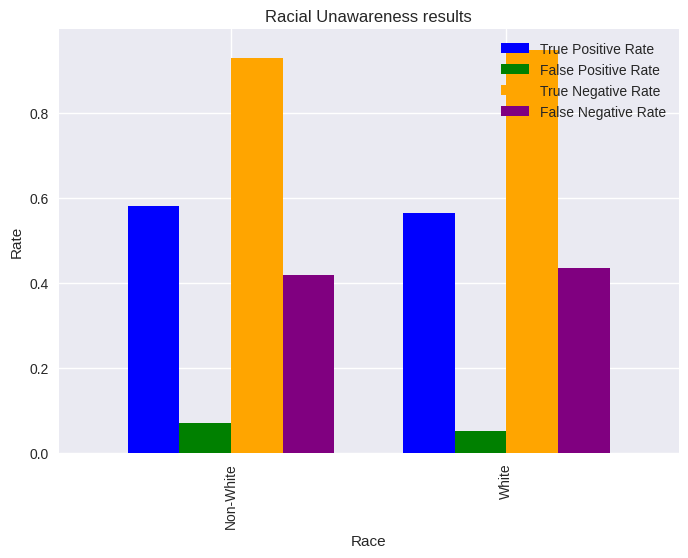

In [49]:
X_test['is_white']= test_race
print(f"Overall Accuracy: {round(accuracy_score(y_test, y_pred), 4)}")
df_racial_unawareness= create_racial_df(df,X_test, y_test,y_pred)
plot_rates(df_racial_unawareness, title="Racial Unawareness results")

Racial Balance

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Overall Accuracy: 0.8588
Accuracy for Female: 0.926
Accuracy for Male: 0.8164

Rates for Female:
True Positive Rate: 0.45
False Positive Rate: 0.02
True Negative Rate: 0.98
False Negative Rate: 0.55

Rates for Male:
True Positive Rate: 0.63
False Positive Rate: 0.11
True Negative Rate: 0.89
False Negative Rate: 0.37


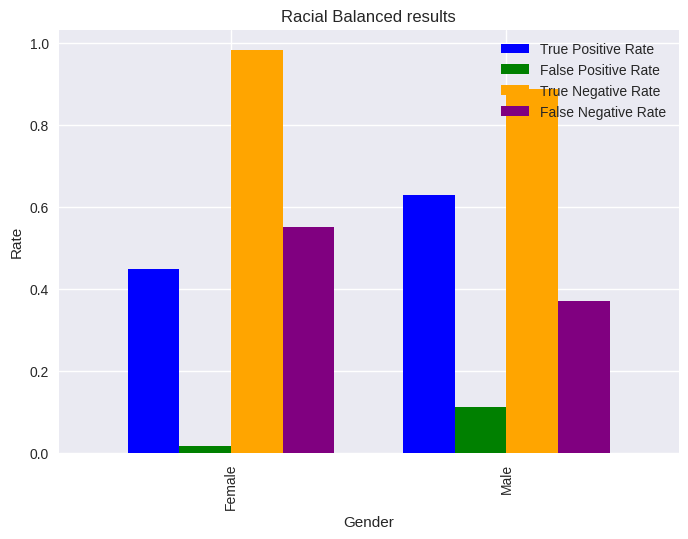

In [50]:
whites, non_whites= df[df.is_white==0], df[df.is_white==1]
sampled_whites= whites.sample(n=int(min(non_whites.shape[0], whites.shape[0]))).reset_index(drop=True)
combined=pd.concat([sampled_whites, non_whites]).sample(frac=1).reset_index(drop=True)
Xvals=combined.drop(["income"], axis=1)
Yvals=combined["income"]
X_train, X_test, y_train, y_test=train_test_split(Xvals, Yvals, test_size=0.2, random_state=42)


y_pred=get_preds(X_train, y_train, X_test)

print(f"Overall Accuracy: {round(accuracy_score(y_test, y_pred), 4)}")
df_racial_balanced= create_racial_df(df, X_test, y_test, y_pred)
gender_plot_rates(df_racial_balanced, title='Racial Balanced results')

Target Ratio Balnce

In [51]:
whites, non_whites= df[df.is_white==0], df[df.is_white==1]
white_high=whites[(whites.income==1)]
white_low=whites[(whites.income==0)]
non_white_high=non_whites[(non_whites.income==1)]
non_white_low=non_whites[(non_whites.income==0)]
print("shapes wh, wl, nwh, nwl:", [x.shape[0] for x  in [white_high, white_low, non_white_high, non_white_low]])
ratio= float(white_high.shape[0])/ float(white_low.shape[0])
print("Ratio is", ratio)

shapes wh, wl, nwh, nwl: [10607, 31155, 1080, 6000]
Ratio is 0.3404589953458514


In [52]:
n_non_white_high= non_white_high.shape[0]
# Calculate n_non_white_low by multiplying instead of dividing
n_non_white_low= int(n_non_white_high * ratio)

_white_low= white_low.copy()
_white_high=white_high.copy()
_non_white_high= non_white_high.copy()
_non_white_low=non_white_low.sample(n=n_non_white_low).reset_index(drop=True)
_combined=pd.concat([_white_high, _white_low,_non_white_high, _non_white_low]).sample(frac=1).reset_index(drop=True)
Xvals= _combined.drop(["income"], axis=1)
Yvals=_combined["income"]
X_train, X_test, y_train, y_test= train_test_split(Xvals, Yvals, test_size=0.2, random_state=42)
y_pred=get_preds(X_train,y_train, X_test )

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Overall Accuracy: 0.8167
Accuracy for White: 0.8183
Accuracy for Non-White: 0.773

Rates for White:
True Positive Rate: 0.61
False Positive Rate: 0.11
True Negative Rate: 0.89
False Negative Rate: 0.39

Rates for Non-White:
True Positive Rate: 0.71
False Positive Rate: 0.07
True Negative Rate: 0.93
False Negative Rate: 0.29


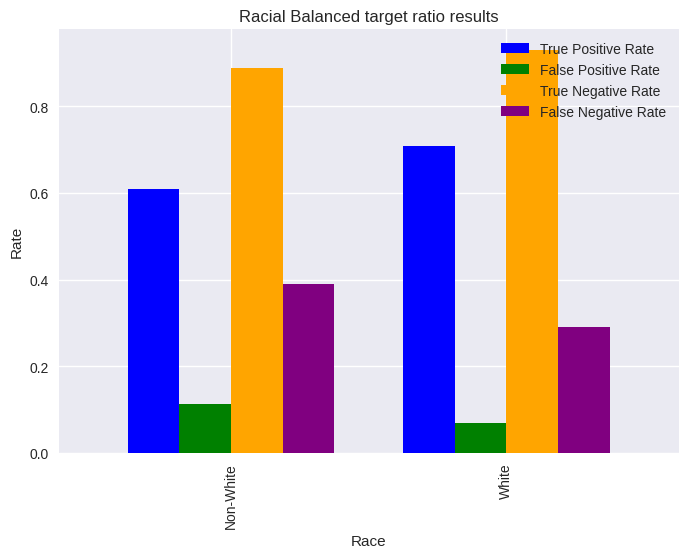

In [53]:
print(f"Overall Accuracy: {round(accuracy_score(y_test, y_pred), 4)}")
df_racial_ratio= create_racial_df(df, X_test, y_test, y_pred)
plot_rates(df_racial_ratio, title="Racial Balanced target ratio results")

Rcaial Counterfactual Augmentation

In [54]:
df_race_tmp=df.copy()
df_race_tmp['is_white']=df_race_tmp['is_white'].apply(lambda value: 1-value)
df_race_aug=pd.concat([df.copy(), df_race_tmp])
X=df_race_aug.drop('income', axis=1)
y=df_race_aug['income']
X_train, X_test,y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=42)
y_pred=get_preds(X_train, y_train, X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Overall Accuracy: 0.832
Accuracy for White: 0.8351
Accuracy for Non-White: 0.8289

Rates for White:
True Positive Rate: 0.59
False Positive Rate: 0.09
True Negative Rate: 0.91
False Negative Rate: 0.41

Rates for Non-White:
True Positive Rate: 0.51
False Positive Rate: 0.07
True Negative Rate: 0.93
False Negative Rate: 0.49


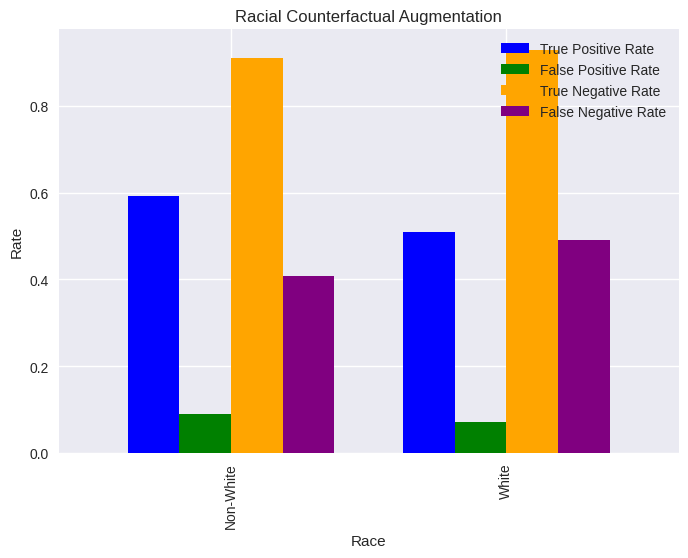

In [55]:
print(f"Overall Accuracy: {round(accuracy_score(y_test, y_pred), 4)}")
df_race_aug=create_racial_df(df, X_test, y_test, y_pred)
plot_rates(df_race_aug, title='Racial Counterfactual Augmentation')

Comparing Results from Different Debiasing Methods:

No Debiasing:
  Overall Accuracy: 0.8683
  White Accuracy: 0.8596
  Non-white Accuracy: 0.9143

Racial Unawareness:
  Overall Accuracy: 0.8614
  White Accuracy: 0.853
  Non-white Accuracy: 0.9061

Racial Balanced Dataset:
  Overall Accuracy: 0.8588
  White Accuracy: 0.8306
  Non-white Accuracy: 0.8863

Racial Balanced Target Ratio:
  Overall Accuracy: 0.8167
  White Accuracy: 0.8183
  Non-white Accuracy: 0.773

Racial Counterfactual Augmentation:
  Overall Accuracy: 0.832
  White Accuracy: 0.8351
  Non-white Accuracy: 0.8289


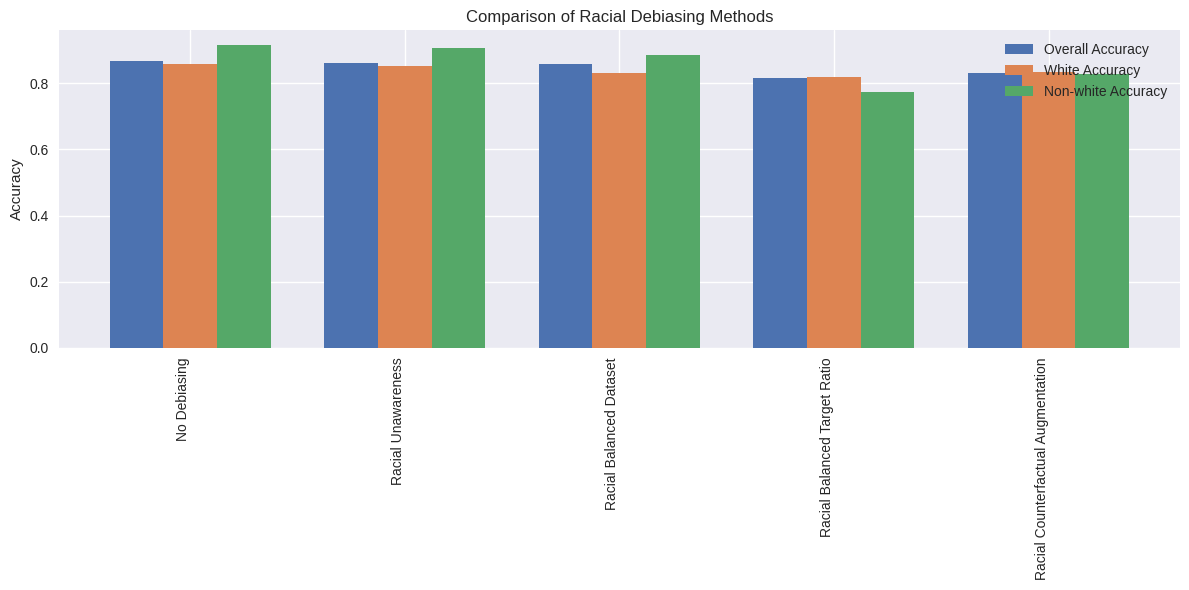

In [56]:
import matplotlib.pyplot as plt

def race_compare_results(df_no_racial_debiasing, df_racial_unawareness, df_racial_balanced, df_racial_ratio, df_race_aug):

    print("Comparing Results from Different Debiasing Methods:")

    def calculate_metrics(df):
        overall_accuracy = accuracy_score(df['true_label'], df['predicted_label'])
        white_accuracy = accuracy_score(df[df['is_white'] == 0]['true_label'], df[df['is_white'] == 0]['predicted_label'])
        non_white_accuracy = accuracy_score(df[df['is_white'] == 1]['true_label'], df[df['is_white'] == 1]['predicted_label'])
        return overall_accuracy, white_accuracy, non_white_accuracy

    methods = {
        "No Debiasing": df_no_racial_debiasing,
        "Racial Unawareness": df_racial_unawareness,
        "Racial Balanced Dataset": df_racial_balanced,
        "Racial Balanced Target Ratio": df_racial_ratio,
        "Racial Counterfactual Augmentation": df_race_aug
    }

    overall_accuracies = []
    white_accuracies = []
    non_white_accuracies = []
    method_names = []

    for method_name, df in methods.items():
        overall_accuracy, white_accuracy, non_white_accuracy = calculate_metrics(df)
        print(f"\n{method_name}:")
        print(f"  Overall Accuracy: {round(overall_accuracy, 4)}")
        print(f"  White Accuracy: {round(white_accuracy, 4)}")
        print(f"  Non-white Accuracy: {round(non_white_accuracy, 4)}")


        method_names.append(method_name)
        overall_accuracies.append(overall_accuracy)
        white_accuracies.append(white_accuracy)
        non_white_accuracies.append(non_white_accuracy)

    x = range(len(method_names))
    width = 0.25

    plt.figure(figsize=(12, 6))

    plt.bar(x, overall_accuracies, width=width, label='Overall Accuracy', align='center')
    plt.bar([i + width for i in x], white_accuracies, width=width, label='White Accuracy', align='center')
    plt.bar([i + 2 * width for i in x], non_white_accuracies, width=width, label='Non-white Accuracy', align='center')


    plt.ylabel('Accuracy')
    plt.title('Comparison of Racial Debiasing Methods')


    plt.xticks([i + width for i in x], method_names, rotation=90, ha='right')

    plt.legend()
    plt.tight_layout()
    plt.show()
race_compare_results(df_no_racial_debiasing, df_racial_unawareness, df_racial_balanced, df_racial_ratio, df_race_aug)


Number of Whites before resampling: 41762
Number of Non-Whites before resampling: 7080


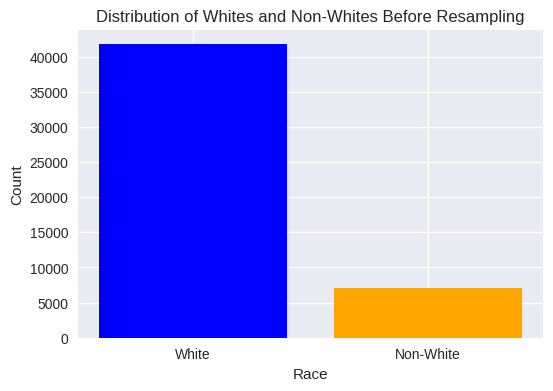

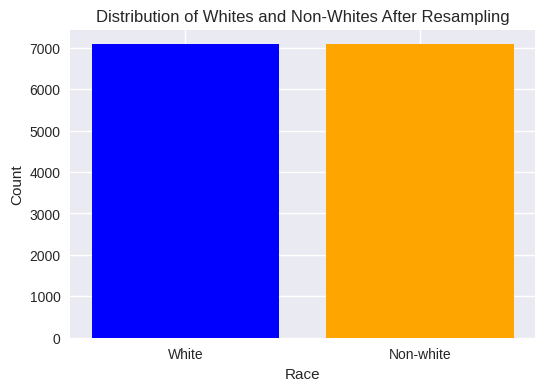

Overall Accuracy: 0.8710

White - True Positive Rate (TPR): 0.6054
White - False Positive Rate (FPR): 0.0777
White - True Negative Rate (TNR): 0.9223
White - False Negative Rate (FNR): 0.3946

Non-White - True Positive Rate (TPR): 0.4847
Non-White - False Positive Rate (FPR): 0.0281
Non-White - True Negative Rate (TNR): 0.9719
Non-White - False Negative Rate (FNR): 0.5153


array([[1767,   51],
       [ 168,  158]])

In [59]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

whites = df[df['is_white'] == 0]
non_whites = df[df['is_white'] == 1]


print(f"Number of Whites before resampling: {len(whites)}")
print(f"Number of Non-Whites before resampling: {len(non_whites)}")

plt.figure(figsize=(6, 4))
plt.bar(['White', 'Non-White'], [len(whites), len(non_whites)], color=['blue', 'orange'])
plt.title('Distribution of Whites and Non-Whites Before Resampling')
plt.xlabel('Race')
plt.ylabel('Count')
plt.show()


if len(whites) > len(non_whites):
    whites_resampled = whites.sample(n=len(non_whites), random_state=42)
    df_balanced = pd.concat([whites_resampled, non_whites], axis=0)
else:
    non_whites_resampled = non_whites.sample(n=len(whites), random_state=42)
    df_balanced = pd.concat([non_whites_resampled, whites], axis=0)


df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


whites_after = df_balanced[df_balanced['is_white'] == 0]
non_whites_after = df_balanced[df_balanced['is_white'] == 1]

plt.figure(figsize=(6, 4))
plt.bar(['White', 'Non-white'], [len(whites_after), len(non_whites_after)], color=['blue','orange'])
plt.title('Distribution of Whites and Non-Whites After Resampling')
plt.xlabel('Race')
plt.ylabel('Count')
plt.show()

X = df_balanced.drop('income', axis=1)
y = df_balanced['income']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(solver='liblinear', max_iter=5000)
log_reg.fit(X_train_scaled, y_train)


y_pred = log_reg.predict(X_test_scaled)


overall_accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {overall_accuracy:.4f}")


def compute_rates_for_group(y_true, y_pred, group_name):
    conf_matrix = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = conf_matrix.ravel()


    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    TNR = TN / (TN + FP)
    FNR = FN / (FN + TP)

    print(f"\n{group_name} - True Positive Rate (TPR): {TPR:.4f}")
    print(f"{group_name} - False Positive Rate (FPR): {FPR:.4f}")
    print(f"{group_name} - True Negative Rate (TNR): {TNR:.4f}")
    print(f"{group_name} - False Negative Rate (FNR): {FNR:.4f}")
    return conf_matrix


whites_mask = X_test['is_white'] == 0
compute_rates_for_group(y_test[whites_mask], y_pred[whites_mask], "White")


non_whites_mask = X_test['is_white'] == 1
compute_rates_for_group(y_test[non_whites_mask], y_pred[non_whites_mask], "Non-White")


In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Accuracy: 0.8709981167608286
Precision: 0.7314814814814815
Recall: 0.5589622641509434
F1-score: 0.6336898395721925


Mitigating Bias through fairmodel selection

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

In [62]:
LR_MAX_ITER=1000
MLP_MAX_ITER=10000

In [63]:
df_copy= df.copy()

In [64]:
def get_naive_dataset(df):

    from sklearn.model_selection import train_test_split
    X = df.drop('income', axis=1)
    y = df['income']
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return (x_train, y_train), (x_test, y_test)

In [65]:
(x_train, y_train), (x_test, y_test) = get_naive_dataset(df_copy)

In [66]:
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=1, max_iter=LR_MAX_ITER) # GLM
rf = RandomForestClassifier(n_estimators=50, random_state=1) # Random Forest
gnb = GaussianNB() # GLM
mlp = MLPClassifier(max_iter=MLP_MAX_ITER)  # ANN
svc = svm.SVC() # SVM
knc = KNeighborsClassifier(n_neighbors=5)
for model in [lr, rf, gnb, mlp, svc, knc]:
    model.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
for model_name, model in [('LR', lr), ('RF', rf), ('GNB', gnb), ('MLP', mlp), ('svc', svc), ('knc', knc)]:
    print(model_name, ' accuracy: ', accuracy_score(y_test, model.predict(x_test)))

LR  accuracy:  0.8285392568328386
RF  accuracy:  0.8442010441191524
GNB  accuracy:  0.7909714402702426
MLP  accuracy:  0.7919950864981062
svc  accuracy:  0.7976251407513564
knc  accuracy:  0.7783805916675197


In [ ]:
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = get_naive_dataset(df_copy)
model_names = ['LR', 'RF', 'GNB', 'MLP', 'svc', 'knc']
accuracies = []
for model_name, model in [('LR', lr), ('RF', rf), ('GNB', gnb), ('MLP', mlp), ('svc', svc), ('knc', knc)]:
    accuracies.append(accuracy_score(y_test, model.predict(x_test)))


Debiasing through multi-model architecture

A multi-model architecture combines different machine learning models, and makes a prediction by taking into account the predictions of multiple models.

There are different ways in which a multi-model architecture can make a decision, but here, we will be looking at a Voting classifier, that uses either the Soft Votingrule or Majority/Hard voting rule to make predictions. In Soft-Voting, outputs fom multiple models are averaged. In the majority rule, the majority output/prediction wins.

In [68]:
from sklearn.ensemble import VotingClassifier

In [69]:
def default_voting_classifier(voting='hard'):
    lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=1, max_iter=LR_MAX_ITER)
    rf = RandomForestClassifier(n_estimators=50, random_state=1)
    gnb = GaussianNB()
    mlp = MLPClassifier(max_iter=MLP_MAX_ITER)
    svc = svm.SVC(probability = voting != 'hard')
    knc = KNeighborsClassifier(n_neighbors=5)
    voter = VotingClassifier(estimators=[('LR', lr), ('RF', rf), ('GNB', gnb), ('MLP', mlp), ('svc', svc)], voting=voting)

    return voter

In [70]:
(x_train, y_train), (x_test, y_test) = get_naive_dataset(df_copy)

In [71]:
hardvoter = default_voting_classifier(voting='hard')
softvoter = default_voting_classifier(voting='soft')
for model in [hardvoter, softvoter]:
    model.fit(x_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in ve

In [72]:
print('Hard voting accuracy ', accuracy_score(y_test, hardvoter.predict(x_test)))
print('Soft voting accuracy ', accuracy_score(y_test, softvoter.predict(x_test)))

Hard voting accuracy  0.813798751151602
Soft voting accuracy  0.8187122530453476


In [73]:
modelNames = ['LR', 'RF', 'GNB', 'MLP', 'SVC', 'hard_voter', 'soft_voter']
models = [lr, rf, gnb, mlp, svc, hardvoter, softvoter]

In [74]:
def evaluate_predictor_performance(predictions, x_test, y_test):

    accuracy = accuracy_score(y_test, predictions)

    # Return the evaluation metrics
    return {'accuracy': accuracy}

summaries = []
for model, modelname in zip(models, modelNames):
    summaries.append(evaluate_predictor_performance(model.predict(x_test), x_test, y_test))

compare model performaance 1 training

In [75]:
overall_accuracies = [summary['accuracy'] for summary in summaries]

Accuracy for LR: 0.8285
Accuracy for RF: 0.8442
Accuracy for GNB: 0.7910
Accuracy for MLP: 0.7920
Accuracy for SVC: 0.7976
Accuracy for hard_voter: 0.8138
Accuracy for soft_voter: 0.8187


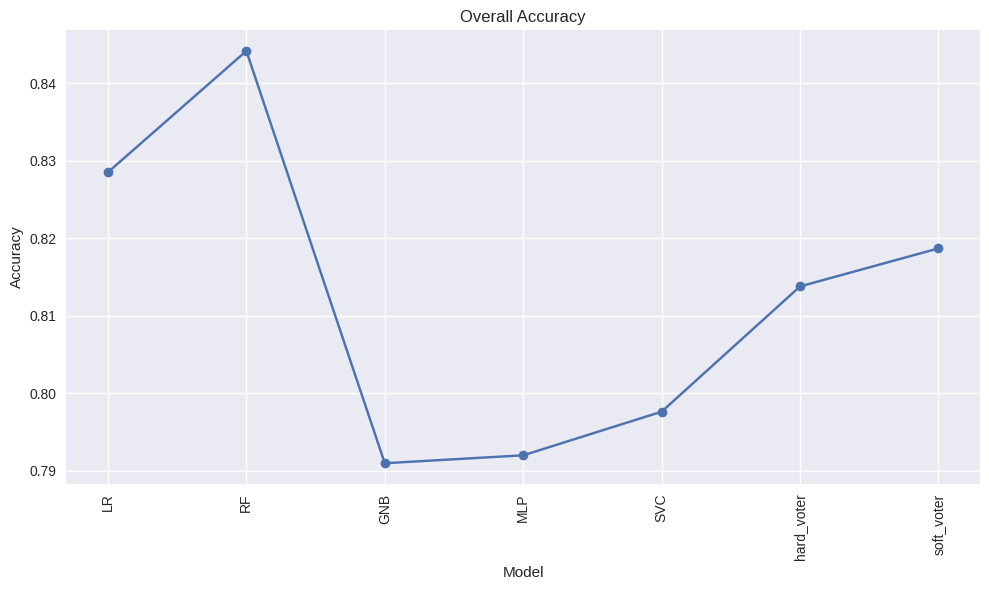

In [76]:
def evaluate_predictor_performance(predictions, y_test):
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_test, predictions)
    return {'accuracy': accuracy}

summaries = []
for model, modelname in zip(models, modelNames):
    # Get predictions and evaluate performance
    predictions = model.predict(x_test)
    summary = evaluate_predictor_performance(predictions, y_test)

    # Append summary
    summaries.append(summary)

    # Print the accuracy of each model
    print(f"Accuracy for {modelname}: {summary['accuracy']:.4f}")

# Extract overall accuracies for plotting
overall_accuracies = [summary['accuracy'] for summary in summaries]

def plot_comparisons(modelNames, overall_accuracies, title, rotation='vertical'):
    plt.figure(figsize=(10, 6))
    plt.plot(modelNames, overall_accuracies, marker='o')
    plt.xlabel("Model")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

# Plot the comparisons
plot_comparisons(modelNames, overall_accuracies, "Overall Accuracy", rotation='vertical')


compare model performance mulitiple training

In [77]:
# def get_model_class_summaries(model_class, dataset, training_sessions, *args, **kwargs):
#     """
#     Repeatedly sample from the dataset, train, test and return summary statistics
#     """
#     assert training_sessions >= 1, "Must train at least once"

#     Xvals, Yvals = dataset
#     summaries = []
#     for session in range(training_sessions):
#         x_train, x_test, y_train, y_test = train_test_split(Xvals, Yvals, test_size=.25)
#         model = model_class(*args, **kwargs)
#         model.fit(x_train, y_train)

#         evaluation = evaluate_predictor_performance(model.predict(x_test), x_test, y_test)
#         summaries.append(evaluation)

#     assert len(summaries) == training_sessions
#     return summaries

In [78]:
def get_model_class_summaries(model_class, dataset, training_sessions, *args, **kwargs):
    """
    Repeatedly sample from the dataset, train, test and return summary statistics
    """
    assert training_sessions >= 1, "Must train at least once"

    Xvals, Yvals = dataset
    summaries = []
    for session in range(training_sessions):
        x_train, x_test, y_train, y_test = train_test_split(Xvals, Yvals, test_size=.25)
        model = model_class(*args, **kwargs)
        model.fit(x_train, y_train)

        # Removed the extra argument x_test here
        evaluation = evaluate_predictor_performance(model.predict(x_test), y_test)
        summaries.append(evaluation)

    assert len(summaries) == training_sessions
    return summaries

In [79]:
dataset = df_copy.copy()
Xvals=dataset.drop(["income"], axis=1)
Yvals = dataset["income"]
some_summaries = get_model_class_summaries(MLPClassifier, (Xvals, Yvals), 5, max_iter=MLP_MAX_ITER)
some_summaries[:5]

[{'accuracy': 0.23773646711981},
 {'accuracy': 0.6881500286626812},
 {'accuracy': 0.31135861108836294},
 {'accuracy': 0.7874047989517649},
 {'accuracy': 0.783064450085988}]

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

model = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', max_iter=1000))

scores = cross_val_score(model, X, y, cv=5)
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())


Cross-validation scores: [0.87429379 0.86334746 0.85769774 0.86087571 0.85769774]
Mean cross-validation score: 0.8627824858757063


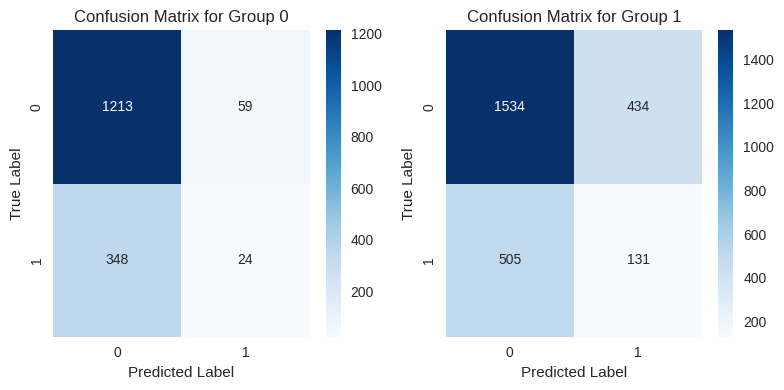

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_fairness_confusion_matrix(y_true, y_pred, sensitive_attribute):

  group_labels = sorted(list(set(sensitive_attribute)))
  group_confusion_matrices = {}
  for label in group_labels:
    indices = [i for i, attr in enumerate(sensitive_attribute) if attr == label]
    group_confusion_matrices[label] = confusion_matrix(
        [y_true.iloc[i] for i in indices],
        [y_pred[i] for i in indices]
    )

  # Plotting the confusion matrices
  num_groups = len(group_labels)
  fig, axes = plt.subplots(1, num_groups, figsize=(4 * num_groups, 4))
  if num_groups == 1:
    axes = [axes]

  for i, label in enumerate(group_labels):
      cm = group_confusion_matrices[label]
      sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
      axes[i].set_title(f'Confusion Matrix for Group {label}')
      axes[i].set_xlabel('Predicted Label')
      axes[i].set_ylabel('True Label')

  plt.tight_layout()
  plt.show()
plot_fairness_confusion_matrix(y_test, y_pred, X_test['is_male'][:len(y_test)])

In [82]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import mode

# Load or generate a dataset (using a simple example here)
# Assuming df is a Pandas DataFrame with features and 'income' as the target column
# X = Features, y = Target
X = df.drop('income', axis=1)
y = df['income']

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize multiple models
log_reg = LogisticRegression(max_iter=1000)
random_forest = RandomForestClassifier(n_estimators=100)
mlp = MLPClassifier(max_iter=500)

# Train the models
log_reg.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
mlp.fit(X_train, y_train)

# Get predictions from each model
log_reg_preds = log_reg.predict(X_test)
rf_preds = random_forest.predict(X_test)
mlp_preds = mlp.predict(X_test)

# Combine predictions using majority voting
combined_preds = np.array([log_reg_preds, rf_preds, mlp_preds])
final_preds, _ = mode(combined_preds, axis=0)

# Evaluate the performance of each model individually
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, log_reg_preds):.4f}")
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_preds):.4f}")
print(f"MLP Classifier Accuracy: {accuracy_score(y_test, mlp_preds):.4f}")

# Evaluate the performance of the multi-model architecture (combined predictions)
print(f"Combined Model Accuracy (Majority Voting): {accuracy_score(y_test, final_preds.flatten()):.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.8299
Random Forest Accuracy: 0.8477
MLP Classifier Accuracy: 0.7918
Combined Model Accuracy (Majority Voting): 0.8362


In [83]:
!pip install aif360

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch 0; iter: 0; batch classifier loss: 0.789057; batch adversarial loss: 0.803118
epoch 0; iter: 200; batch classifier loss: 0.328421; batch adversarial loss: 0.591666
epoch 1; iter: 0; batch classifier loss: 0.355819; batch adversarial loss: 0.587071
epoch 1; iter: 200; batch classifier loss: 0.253700; batch adversarial loss: 0.440899
epoch 2; iter: 0; batch classifier loss: 0.308391; batch adversarial loss: 0.440479
epoch 2; iter: 200; batch classifier loss: 0.352824; batch adversarial loss: 0.420125
epoch 3; iter: 0; batch classifier loss: 0.379249; batch adversarial loss: 0.391579
epoch 3; iter: 200; batch classifier loss: 0.263515; batch adversarial loss: 0.161732
epoch 4; iter: 0; batch classifier loss: 0.270565; batch adversarial loss: 0.310513
epoch 4; iter: 200; batch classifier loss: 0.300655; batch adversarial loss: 0.154183
epoch 5; iter: 0; batch classifier loss: 0.315571; batch adversarial loss: 0.226727
epoch 5; iter: 200; batch classifier loss: 0.367565; batch adversa

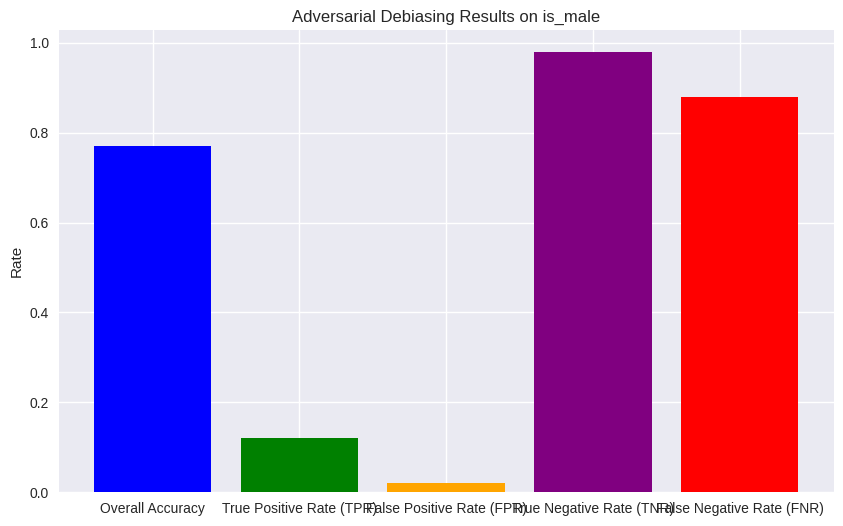

In [84]:
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.datasets import BinaryLabelDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import numpy as np

# Tensorflow setup for adversarial debiasing
tf.disable_eager_execution()

# Prepare your dataset (assuming df is the original dataframe with 'is_male' as the sensitive feature and 'income' as the label)
# Split into features (X) and target (y)
X = df.drop('income', axis=1)
y = df['income']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to aif360 BinaryLabelDataset format
train_dataset = BinaryLabelDataset(favorable_label=1, unfavorable_label=0,
                                   df=pd.DataFrame(np.hstack((X_train_scaled, y_train.values.reshape(-1, 1))),
                                                   columns=list(X.columns) + ['income']),
                                   label_names=['income'], protected_attribute_names=['is_male'])

test_dataset = BinaryLabelDataset(favorable_label=1, unfavorable_label=0,
                                  df=pd.DataFrame(np.hstack((X_test_scaled, y_test.values.reshape(-1, 1))),
                                                  columns=list(X.columns) + ['income']),
                                  label_names=['income'], protected_attribute_names=['is_male'])

# Adversarial Debiasing Model Setup
sess = tf.Session()
adversarial_model = AdversarialDebiasing(privileged_groups=[{'is_male': 1}],
                                         unprivileged_groups=[{'is_male': 0}],
                                         scope_name='debias_classifier',
                                         debias=True,
                                         sess=sess)

# Train the adversarial debiasing model
adversarial_model.fit(train_dataset)

# Make predictions on the test set
predictions = adversarial_model.predict(test_dataset)

# Extract true labels and predicted labels
y_true = test_dataset.labels.ravel()
y_pred = predictions.labels.ravel()

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Compute True Positive Rate (TPR), False Positive Rate (FPR), True Negative Rate (TNR), and False Negative Rate (FNR)
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate

# Print the rates
print(f"True Positive Rate (TPR): {tpr:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"True Negative Rate (TNR): {tnr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")

# Plotting the results
categories = ['Overall Accuracy', 'True Positive Rate (TPR)', 'False Positive Rate (FPR)', 'True Negative Rate (TNR)', 'False Negative Rate (FNR)']
values = [accuracy, tpr, fpr, tnr, fnr]

plt.figure(figsize=(10, 6))
plt.bar(categories, values, color=['blue', 'green', 'orange', 'purple', 'red'])
plt.title('Adversarial Debiasing Results on is_male')
plt.ylabel('Rate')
plt.show()


Metrics by group:
             TPR       TNR       FPR       FNR
Male    0.675676  0.945438  0.054562  0.324324
Female  0.018401  0.999853  0.000147  0.981599

Overall accuracy: 0.7713778748379172


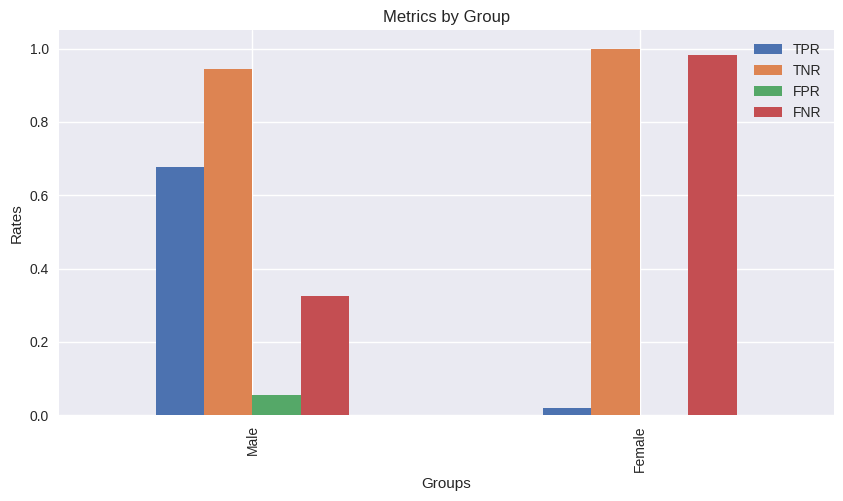

In [85]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def calculate_metrics(y_true, y_pred, sensitive_attribute):
    groups = np.unique(sensitive_attribute)
    metrics_dict = {}

    group_names = {0: 'Male', 1: 'Female'}

    for group in groups:

        y_true_group = y_true[sensitive_attribute == group]
        y_pred_group = y_pred[sensitive_attribute == group]


        tn, fp, fn, tp = confusion_matrix(y_true_group, y_pred_group).ravel()


        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0



        metrics_dict[group_names[group]] = {
            'TPR': tpr,
            'TNR': tnr,
            'FPR': fpr,
            'FNR': fnr
        }

    overall_accuracy = accuracy_score(y_true, y_pred)


    metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')
    return metrics_df, overall_accuracy


metrics_df, accuracy = calculate_metrics(y_true, y_pred, X_test['is_male'])
print("Metrics by group:")
print(metrics_df)
print("\nOverall accuracy:", accuracy)


metrics_df.plot(kind='bar', figsize=(10, 5), title='Metrics by Group')
plt.xlabel('Groups')
plt.ylabel('Rates')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics Before Applying Demographic Parity:
      Group    Metric     Value
0         0       TPR  0.301370
1         0       TNR  0.975244
2         0       FPR  0.024756
3         0       FNR  0.698630
4         0        PR  0.055985
5         1       TPR  0.251256
6         1       TNR  0.964144
7         1       FPR  0.035856
8         1       FNR  0.748744
9         1        PR  0.101438
10  Overall  Accuracy  0.797420
Metrics After Applying Demographic Parity:
      Group    Metric     Value
0         0       TPR  0.405479
1         0       TNR  0.597280
2         0       FPR  0.402720
3         0       FNR  0.594521
4         0        PR  0.403031
5         1       TPR  0.409548
6         1       TNR  0.602948
7         1       FPR  0.397052
8         1       FNR  0.590452
9         1        PR  0.400857
10  Overall  Accuracy  0.554509


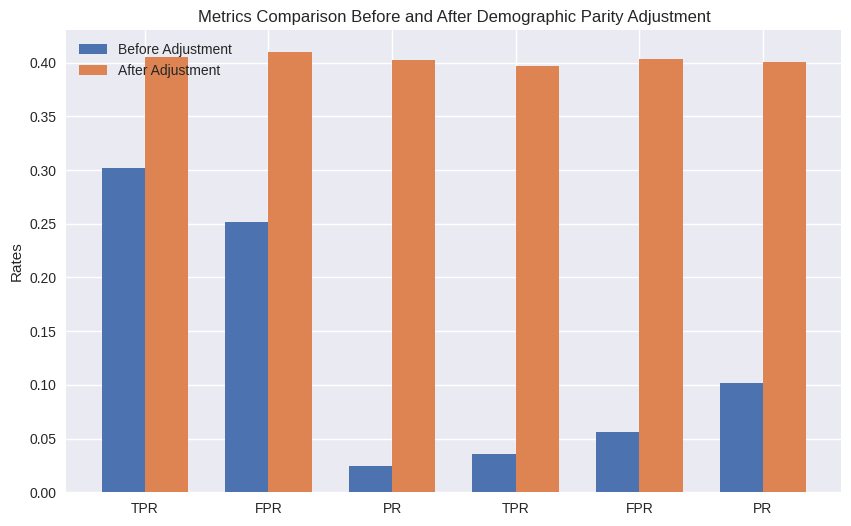

In [86]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

def calculate_metrics(y_true, y_pred, sensitive_attribute):
    groups = np.unique(sensitive_attribute)
    metrics_dict = {}
    group_metrics = {}

    for group in groups:
        idx = (sensitive_attribute == group)
        tn, fp, fn, tp = confusion_matrix(y_true[idx], y_pred[idx]).ravel()


        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        pr = (tp + fp) / len(y_pred[idx]) if len(y_pred[idx]) > 0 else 0


        group_metrics[group] = {
            'TPR': tpr,
            'TNR': tnr,
            'FPR': fpr,
            'FNR': fnr,
            'PR': pr
        }


    accuracy = accuracy_score(y_true, y_pred)
    metrics_dict['Overall'] = {'Accuracy': accuracy}
    metrics_dict['By Group'] = group_metrics

    return metrics_dict

def metrics_to_dataframe(metrics):
    rows = []
    for group, group_metrics in metrics['By Group'].items():
        for metric, value in group_metrics.items():
            rows.append({'Group': group, 'Metric': metric, 'Value': value})
    overall_accuracy = [{'Group': 'Overall', 'Metric': 'Accuracy', 'Value': metrics['Overall']['Accuracy']}]
    return pd.DataFrame(rows + overall_accuracy)

def plot_metrics(before, after):
    labels = ['TPR', 'FPR', 'PR']
    before_values = [before['By Group'][k][label] for label in labels for k in before['By Group']]
    after_values = [after['By Group'][k][label] for label in labels for k in after['By Group']]

    x = np.arange(len(before_values))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, before_values, width, label='Before Adjustment')
    rects2 = ax.bar(x + width/2, after_values, width, label='After Adjustment')

    ax.set_ylabel('Rates')
    ax.set_title('Metrics Comparison Before and After Demographic Parity Adjustment')
    ax.set_xticks(x)
    ax.set_xticklabels(labels * len(before['By Group']))
    ax.legend()

    plt.show()


df_v2 = df_copy.copy()
X = df_v2.drop('income', axis=1)
y = df_v2['income']
sensitive_attribute = df_v2['is_male']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LogisticRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

metrics_before = calculate_metrics(y_test, y_pred, X_test['is_male'])
metrics_before_df = metrics_to_dataframe(metrics_before)
print("Metrics Before Applying Demographic Parity:")
print(metrics_before_df)


adjusted_y_pred = np.array([1 if p > 0.6 else 0 for p in np.random.rand(len(y_pred))])


metrics_after = calculate_metrics(y_test, adjusted_y_pred, X_test['is_male'])
metrics_after_df = metrics_to_dataframe(metrics_after)
print("Metrics After Applying Demographic Parity:")
print(metrics_after_df)

plot_metrics(metrics_before, metrics_after)
